In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [3]:
!pip install roboflow

from roboflow import Roboflow 
rf = Roboflow(api_key="DXb4B94A1xpmpoSfBs45")
project = rf.workspace("itml-project").project("itml-final-project-ai-versus-non-ai-dataset")
dataset = project.version(4).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 973 kB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 145 kB 92.3 MB/s 
     |████████████████████████████████| 138 kB 69.7 MB/s 
     |████████████████████████████████| 178 kB 77.6 MB/s 
     |████████████████████████████████| 67 kB 8.0 MB/s 
     |████████████████████████████████| 62 kB 2.0 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=714f18493cce1f53a14909f154241ab06e321af31da64d5fec6e131e72e174ca
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: certifi
    Found existing installation: certi

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to ITML-Final-Project-AI-versus-Non-AI-Dataset-4 in folder:: 100%|██████████| 1900/1900 [00:00<00:00, 5321.51it/s]


In [4]:
data_loc= dataset.location

In [5]:
preprocess = transforms.Compose([
        #transforms.Resize(64),
        #transforms.CenterCrop(64),
        transforms.ToTensor()
])

In [6]:
from torchvision.datasets import ImageFolder
ai_train = data_loc + '/train'
ai_val = data_loc + '/valid'
ai_train_set = ImageFolder(ai_train,transform = preprocess)
ai_val_set = ImageFolder(ai_val, transform = preprocess)

In [7]:
imgs = torch.stack([img_t for img_t, _ in ai_train_set], dim=3)
imgs.shape

torch.Size([3, 512, 512, 1318])

In [8]:
mean = imgs.view(3, -1).mean(dim=1)  # <1>
std = imgs.view(3, -1).std(dim=1)
preprocess2 = transforms.Compose([
        #transforms.Resize(64),
        #transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(
        mean= mean,
        std= std)
])
ai_train_set = ImageFolder(ai_train,transform = preprocess2)
ai_val_set = ImageFolder(ai_val, transform = preprocess2)

In [9]:
train_dataloader = torch.utils.data.DataLoader(ai_train_set, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(ai_val_set, batch_size=64, shuffle=False, num_workers=2)


In [49]:
model = models.resnet34(pretrained=False)   #load resnet34 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 2) #(num_of_class == 2)
model = model.to(device) 
criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


In [50]:
num_epochs = 10   #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(ai_train_set)
    epoch_acc = running_corrects / len(ai_val_set) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(ai_val_set)
        epoch_acc = running_corrects / len(ai_val_set) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #0] Loss: 0.6777 Acc: 210.4278% Time: 8.9275s
[Test #0] Loss: 0.6630 Acc: 67.1123% Time: 11.9550s
Epoch 1 running
[Train #1] Loss: 0.5249 Acc: 272.7273% Time: 20.8522s
[Test #1] Loss: 0.4831 Acc: 76.2032% Time: 23.8250s
Epoch 2 running
[Train #2] Loss: 0.4022 Acc: 296.2567% Time: 32.6538s
[Test #2] Loss: 0.4285 Acc: 83.4225% Time: 35.6220s
Epoch 3 running
[Train #3] Loss: 0.3544 Acc: 300.2674% Time: 44.5260s
[Test #3] Loss: 0.4152 Acc: 83.4225% Time: 47.4542s
Epoch 4 running
[Train #4] Loss: 0.3245 Acc: 305.6150% Time: 56.3251s
[Test #4] Loss: 0.4225 Acc: 81.0160% Time: 59.3187s
Epoch 5 running
[Train #5] Loss: 0.3228 Acc: 305.3476% Time: 68.2061s
[Test #5] Loss: 0.3431 Acc: 85.5615% Time: 71.1410s
Epoch 6 running
[Train #6] Loss: 0.2864 Acc: 309.0909% Time: 80.0386s
[Test #6] Loss: 0.3098 Acc: 87.4332% Time: 82.9981s
Epoch 7 running
[Train #7] Loss: 0.2586 Acc: 313.9037% Time: 91.8597s
[Test #7] Loss: 0.3487 Acc: 85.5615% Time: 94.7974s
Epoch 8 running
[Train #8

In [51]:
torch.save(model.state_dict(), '/content/drive/MyDrive/4101_model_RESULTS/'+ 'res_net34_not_pretrained.pt')

In [52]:
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean_np = np.array(mean)
    std_np = np.array(std)
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

======>RESULTS<======


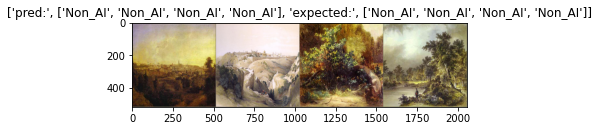

[Test #9] Loss: 0.1971 Acc: 93.5829% Time: 3.3291s


In [53]:
##Testing
class_names = ['AI','Non_AI']
model.eval()
start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if i == 4:
            print('======>RESULTS<======')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=['pred:',[class_names[Y] for Y in preds[:4]], 'expected:',[class_names[x] for x in labels[:4]]])
    epoch_loss = running_loss / len(ai_val_set)
    epoch_acc = running_corrects / len(ai_val_set) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
          format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

In [29]:
loaded_model
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/4101_model_RESULTS/res_net34_not_pretrained.pt'))

NameError: ignored

In [54]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        inputs=inputs.to(device); labels=labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).cpu().detach().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().detach().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('nonai','AI')

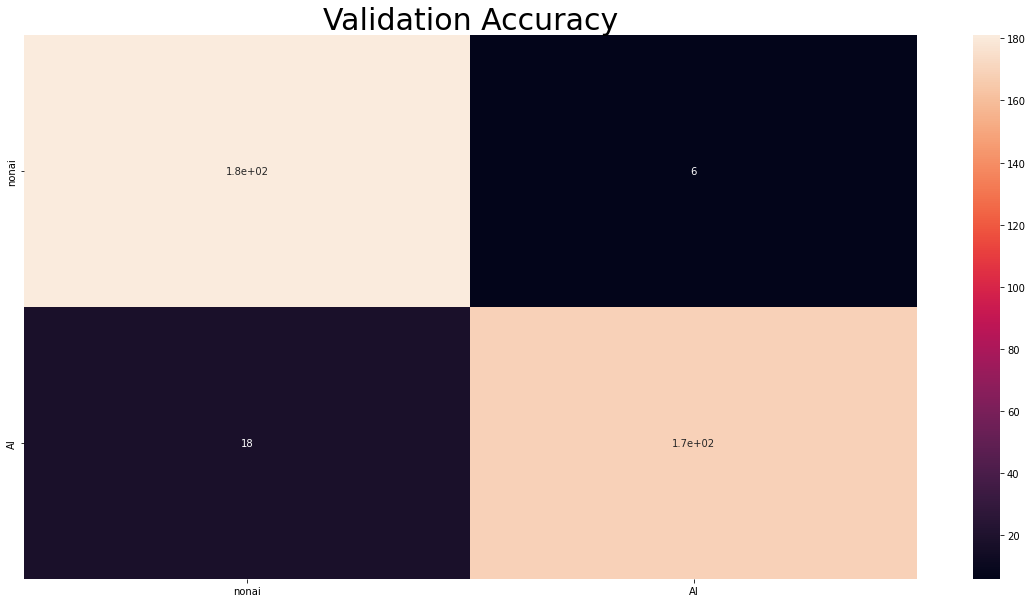

In [55]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
plt.title('Validation Accuracy',fontsize = 30 )
sn.heatmap(df_cm, annot=True)

plt.savefig('/content/drive/MyDrive/4101_model_RESULTS/CnfMatrix_ResNet34_not_pretrained.png')